In [1]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [2]:
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange', 
    'drug': 'tab:green',
    'cytokine': 'tab:olive'
}

# Load data

In [3]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']

del h5_files['XieHon2017']
datasets = list(h5_files.keys())
print(len(datasets))

34


In [4]:
from sklearn.metrics import pairwise_distances

# Compute pairwise whatever

In [5]:
# sigma expresses the variation within one distribution. Ideas:
# standard deviation / variation / dispersion
# mean pairwise distances within distribution

In [7]:
SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'

In [22]:
def compute_pairwise_distances(adata, obs_key, obsm_key='X_pca', cluster=True):
    perturbations = pd.unique(adata.obs.perturbation)
    df = pd.DataFrame(index=perturbations, columns=perturbations, dtype=float)
    for i, p1 in enumerate(tqdm(perturbations)):
        for p2 in perturbations[i:]:
            x1 = adata[adata.obs.perturbation==p1].obsm[obsm_key].copy()
            x2 = adata[adata.obs.perturbation==p2].obsm[obsm_key].copy()
            pwd = pairwise_distances(x1, x2)
            # inverse_mean_pwd = 1/np.mean(pwd)
            mean_pwd = np.mean(pwd)
            df.loc[p1, p2] = mean_pwd
            df.loc[p2, p1] = mean_pwd
    return df

In [23]:
# top50 gene expr  space
adata = sc.read(SDIR+'tmp_data_PapalexiSatija2021_eccite_RNA.h5')
top50 = adata.var.ncounts.sort_values(ascending=False).index[:50]
adata.obsm['X_tmp'] = adata[:, top50].X.A

In [25]:
df = compute_pairwise_distances(adata, 'perturbation', obsm_key='X_tmp', cluster=True)

100%|██████████| 84/84 [01:00<00:00,  1.40it/s]


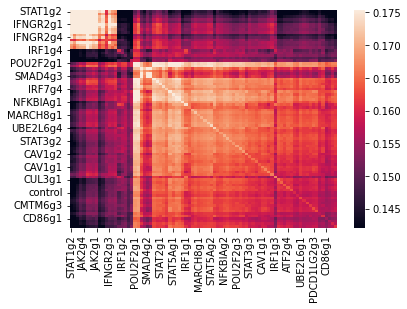

In [28]:
df_ = 1/df
df_ = cluster_matrix(df_, 'both')
sns.heatmap(df_, robust=True)
pl.show()

In [29]:
tab = df
sigma = tab.loc['control', 'control']
# this is the average inverse delta (delta expresses the variation between two distributions)
sigmas = pd.Series(np.diag(tab), tab.index)
# sigma per sigma
sps = sigmas / sigma

# this is the average sigma (sigma expresses the variation within one distribution)
# sigmas = np.diag(tab) * tab.loc['control', 'control']
# this is the average delta (delta expresses the variation between two distributions)
deltas = tab.loc['control', :]
# delta per sigma
dps = deltas / sigmas

In [ ]:
for key in h5_files.keys():
    try:
        adata = sc.read(SDIR+'tmp_data_' + key + '.h5')
        adata = equal_subsampling(adata, 'perturbation', N_min=50)

        perturbations = pd.unique(adata.obs.perturbation)
        df = pd.DataFrame(index=perturbations, columns=perturbations, dtype=float)
        df_ = pd.DataFrame(index=perturbations, columns=perturbations, dtype=float)
        for p1 in tqdm(perturbations):
            for p2 in perturbations:
                x1 = adata[adata.obs.perturbation==p1].obsm['X_pca'].copy()
                x2 = adata[adata.obs.perturbation==p2].obsm['X_pca'].copy()
                pwd = pairwise_distances(x1, x2)
                df.loc[p1, p2] = 1/np.mean(pwd)
        df = cluster_matrix(df, 'both')
        sns.heatmap(df, robust=True)
        pl.title(key)
        pl.show()
        
        df.to_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv')
    except:
        pass

100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


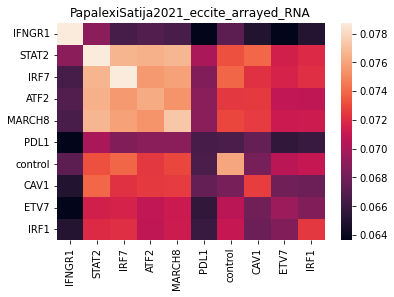

100%|██████████| 84/84 [01:50<00:00,  1.32s/it]


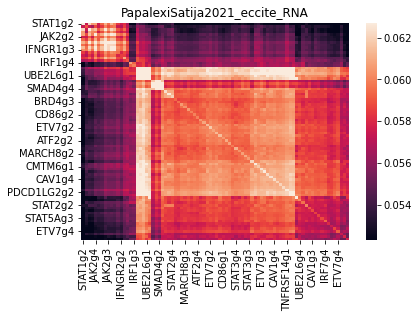

100%|██████████| 184/184 [04:57<00:00,  1.62s/it]


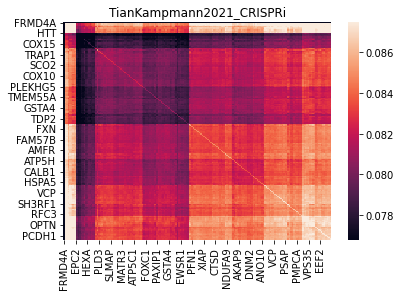

100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


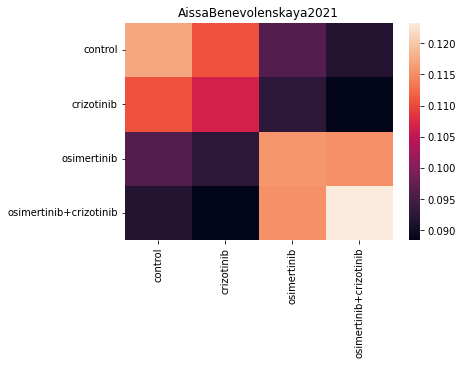

100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


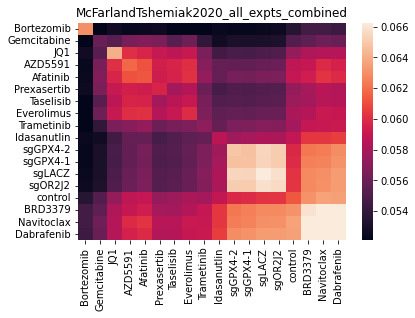

100%|██████████| 2/2 [00:00<00:00, 34.08it/s]


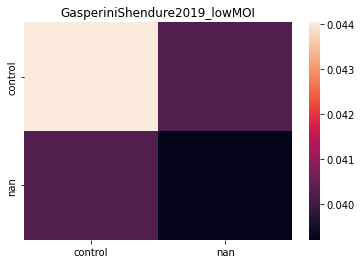

100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


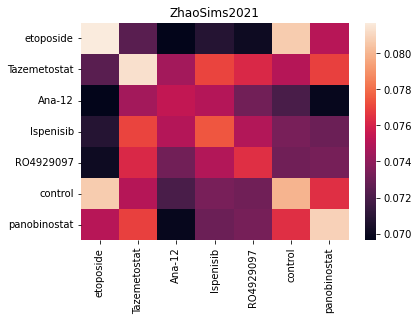

100%|██████████| 60/60 [00:30<00:00,  1.94it/s]


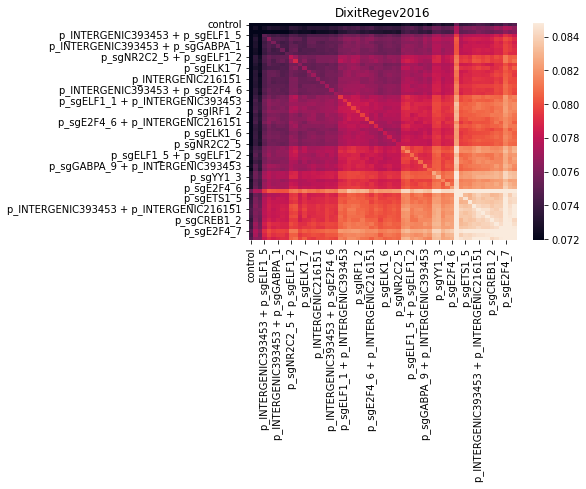

100%|██████████| 45/45 [00:22<00:00,  2.00it/s]


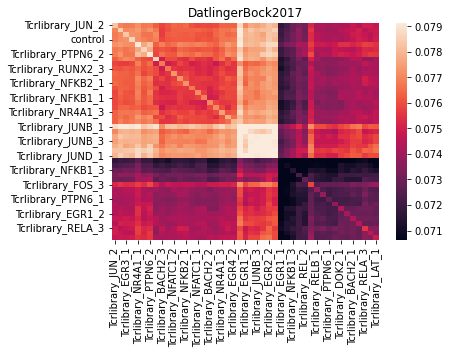

 10%|█         | 5/48 [00:02<00:24,  1.75it/s]


KeyboardInterrupt: 

In [89]:
for key in h5_files.keys():
    try:
        adata = sc.read(SDIR+'tmp_data_' + key + '.h5')
        adata = equal_subsampling(adata, 'perturbation', N_min=50)

        perturbations = pd.unique(adata.obs.perturbation)
        df = pd.DataFrame(index=perturbations, columns=perturbations, dtype=float)
        for p1 in tqdm(perturbations):
            for p2 in perturbations:
                x1 = adata[adata.obs.perturbation==p1].obsm['X_pca'].copy()
                x2 = adata[adata.obs.perturbation==p2].obsm['X_pca'].copy()
                pwd = pairwise_distances(x1, x2)
                df.loc[p1, p2] = 1/np.mean(pwd)
        df = cluster_matrix(df, 'both')
        sns.heatmap(df, robust=True)
        pl.title(key)
        pl.show()
        
        df.to_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv')
    except:
        pass

# Sigma vs Sigma

GasperiniShendure2019_atscale
GasperiniShendure2019_highMOI
DatlingerBock2021
WeinrebKlein2020
ReplogleWeissman2022_K562_essential
ReplogleWeissman2022_K562_gwps
ReplogleWeissman2022_rpe1
GehringPachter2019
SchiebingerLander2019_GSE115943
SchiebingerLander2019_GSE106340
SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen
AdamsonWeissman2016_GSM2406677_10X005
AdamsonWeissman2016_GSM2406681_10X010
AdamsonWeissman2016_GSM2406675_10X001


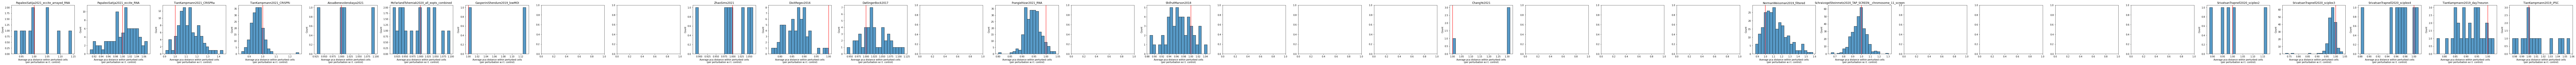

In [236]:
# sigma vs sigma
# did sigma increase in any perturbations?
D = len(datasets)
fig, axs = pl.subplots(1, D, figsize=[6*D,4])
for ax, key in zip(axs, datasets):
    try:
        df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
        df = 1/df  # redo inversion to get distances

        # this is inverse sigma (sigma expresses the variation within one distribution)
        sigma = df.loc['control', 'control']
        # this is the average inverse delta (delta expresses the variation between two distributions)
        sigmas = np.diag(df)
        # sigma per sigma
        sps = sigmas / sigma

        sns.histplot(sps, bins=20, ax=ax)
        ax.axvline(1, color='red')
        ax.set_xlabel('Average pca distance within perturbed cells\n(per perturbation w.r.t. control)')
        ax.set_title(key)
    except:
        print(key)
pl.show()

In [237]:
#looks really cool for 
cool_ones = ['PapalexiSatija2021_eccite_RNA', 'TianKampmann2021_CRISPRa', 'TianKampmann2021_CRISPRi', 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen', 'SrivatsanTrapnell2020_sciplex3', 'DixitRegev2016', 'DatlingerBock2017', 'FrangiehIzar2021_RNA', 'ShifrutMarson2018']

In [238]:
spss = {}
for key in cool_ones:
    tab = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    tab = 1/tab  # redo inversion to get distances

    # this is inverse sigma (sigma expresses the variation within one distribution)
    sigma = tab.loc['control', 'control']
    # this is the average inverse delta (delta expresses the variation between two distributions)
    sigmas = pd.Series(np.diag(tab), tab.index)
    # sigma per sigma
    sps = sigmas / sigma
    spss[key] = sps

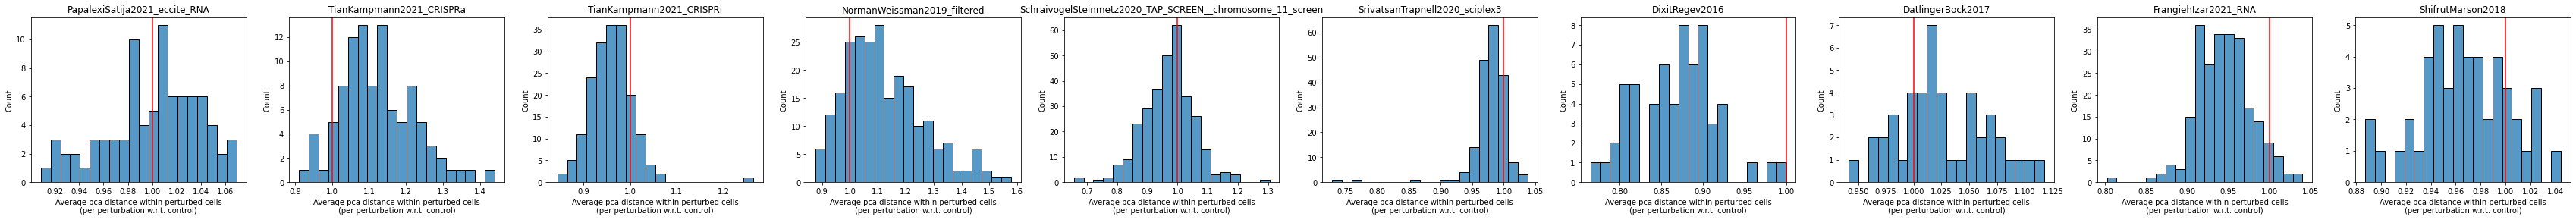

In [239]:
# sigma vs sigma
# did sigma increase in any perturbations?
D = len(cool_ones)
fig, axs = pl.subplots(1, D, figsize=[6*D,4])
for ax, key in zip(axs, cool_ones):
    sps = spss[key]
    sns.histplot(sps, bins=20, ax=ax)
    ax.axvline(1, color='red')
    ax.set_xlabel('Average pca distance within perturbed cells\n(per perturbation w.r.t. control)')
    ax.set_title(key)
pl.show()

In [240]:
# get info from obs
obses = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)
B=pd.DataFrame({name: [list(pd.unique(obs[key]))[0] if key in obs.keys() else None for key in cat_obs_keys] for name, obs in obses.items()}, index=cat_obs_keys).T

In [241]:
# aggregate
df = pd.concat({key: pd.DataFrame(item) for key, item in spss.items()}).reset_index()
df.columns = ['dataset', 'perturbation', 'sps']
df.head()

,dataset,perturbation,sps
0,PapalexiSatija2021_eccite_RNA,control,1.000000
1,PapalexiSatija2021_eccite_RNA,IFNGR2g1,1.002883
2,PapalexiSatija2021_eccite_RNA,ATF2g1,1.009129
3,PapalexiSatija2021_eccite_RNA,IFNGR1g3,0.958253
4,PapalexiSatija2021_eccite_RNA,CD86g1,1.013341


In [242]:
# add info
df = pd.merge(df, B, right_index=True, left_on='dataset')

In [243]:
df.loc[df.dataset=='TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
df.loc[df.dataset=='TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
df.dataset = [x.replace('TAP_SCREEN__', '') for x in df.dataset]
df.dataset = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in df.dataset]
df.dataset = [x.replace('_', ' ') for x in df.dataset]
df = df.sort_values('dataset')

In [244]:
df

,dataset,perturbation,sps,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype
1176,DatlingerBock2017,Tcrlibrary_DOK2_1,1.056745,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells
1179,DatlingerBock2017,Tcrlibrary_DOK2_3,1.024298,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells
1178,DatlingerBock2017,Tcrlibrary_NR4A1_3,1.014096,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells
1177,DatlingerBock2017,Tcrlibrary_RELA_3,1.040796,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells
1175,DatlingerBock2017,Tcrlibrary_RELB_1,1.065422,CRISPR,human,cell_line,Jurkat cells,True,acute T cell leukemia,T cells
...,...,...,...,...,...,...,...,...,...,...
258,TianKampmann2021\n(CRISPRi),FAM57B,0.951994,CRISPRi,human,primary,None,False,healthy,iPSC-induced neuron
259,TianKampmann2021\n(CRISPRi),TRAP1,0.976499,CRISPRi,human,primary,None,False,healthy,iPSC-induced neuron
260,TianKampmann2021\n(CRISPRi),NSF,0.957271,CRISPRi,human,primary,None,False,healthy,iPSC-induced neuron
262,TianKampmann2021\n(CRISPRi),RGL1,0.991311,CRISPRi,human,primary,None,False,healthy,iPSC-induced neuron


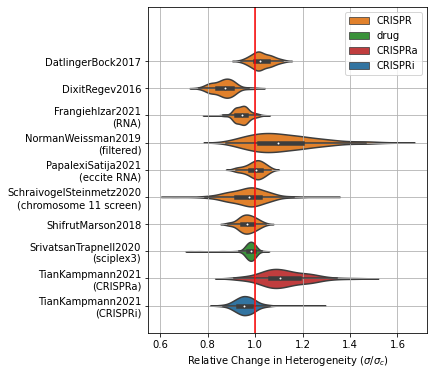

In [245]:
pl.figure(figsize=[5,6])
sns.violinplot(data=df, y='dataset', x='sps', width=0.7, hue='perturbation_type', dodge=False, palette=colors_perturbation_types)
pl.ylim(len(cool_ones), -2)
pl.legend()
pl.axvline(1, color='red')
pl.grid()
pl.ylabel('')
pl.xlabel(r'Relative Change in Heterogeneity ($\sigma/\sigma_c$)')
# pl.title('Gene Expression Heterogeneity ($\sigma$)'+'\nafter Perturbation w.r.t. Unperturbed '+r'($\sigma_c$)')
pl.savefig('../../figures/sigma_vs_sigma.pdf', bbox_inches='tight')
pl.show()

# Delta (vs Delta)

In [38]:
# delta expresses the variation between two distributions (usually perturbation). Ideas:
# mean pairwise distances between distributions
# Wasserstein distance (OT)

In [39]:
# essentially it is the diagonal of the sigma matrices
# No it's not!

# Delta vs Sigma

In [262]:
dpss = {}
for key in cool_ones:
    tab = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    tab = 1/tab  # redo inversion to get distances

    # this is the average sigma (sigma expresses the variation within one distribution)
    sigmas = np.diag(tab) * tab.loc['control', 'control']
    # this is the average delta (delta expresses the variation between two distributions)
    deltas = tab.loc['control', :]
    # delta per sigma
    dps = deltas / sigmas
    dpss[key] = dps

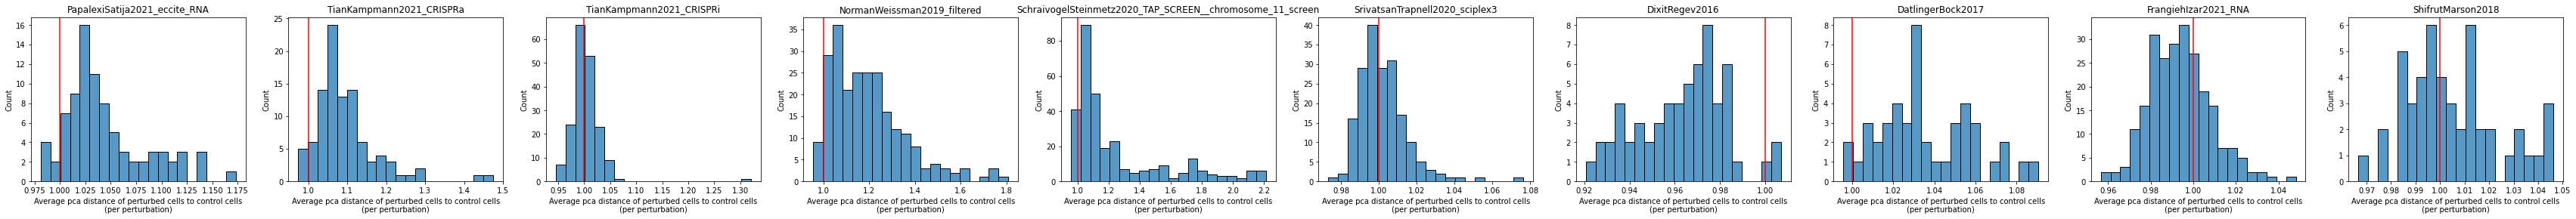

In [41]:
# sigma vs delta

D = len(cool_ones)
fig, axs = pl.subplots(1, D, figsize=[6*D,4])
for ax, key in zip(axs, cool_ones):
    dps = dpss[key]

    sns.histplot(dps, bins=20, ax=ax)
    ax.axvline(1, color='red')
    ax.set_xlabel('Average pca distance of perturbed cells to control cells\n(per perturbation)')
    ax.set_title(key)
pl.show()

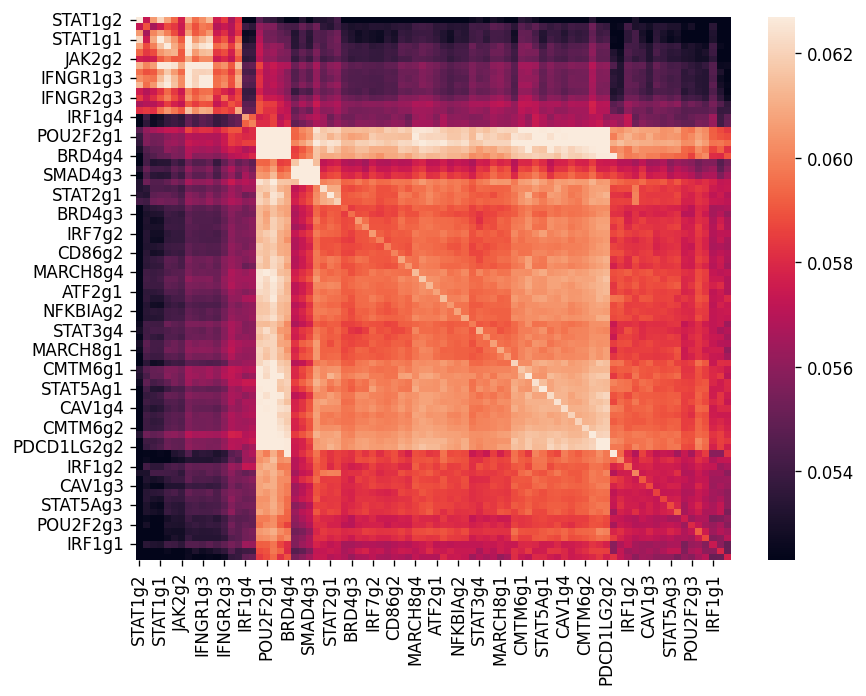

In [211]:
key = 'PapalexiSatija2021_eccite_RNA'
df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
tab = cluster_matrix(df, 'both')
pl.figure(figsize=[8,6], dpi=120)
sns.heatmap(tab, robust=True)
pl.show()

In [263]:
# aggregate
df_ = pd.concat({key: pd.DataFrame(item) for key, item in dpss.items()}).reset_index(level=0)
df_ = df_.reset_index()
df_.columns = ['perturbation', 'dataset', 'dps']
df_ = df_.sort_values('dataset')  # I'm surprised this works
assert all(df_.perturbation.values == df.perturbation.values)
df_.head()

,perturbation,dataset,dps
1176,Tcrlibrary_DOK2_1,DatlingerBock2017,0.078756
1179,Tcrlibrary_DOK2_3,DatlingerBock2017,0.079164
1178,Tcrlibrary_NR4A1_3,DatlingerBock2017,0.079472
1177,Tcrlibrary_RELA_3,DatlingerBock2017,0.079281
1175,Tcrlibrary_RELB_1,DatlingerBock2017,0.077827


In [264]:
# add dps to sps
df['dps'] = df_['dps']

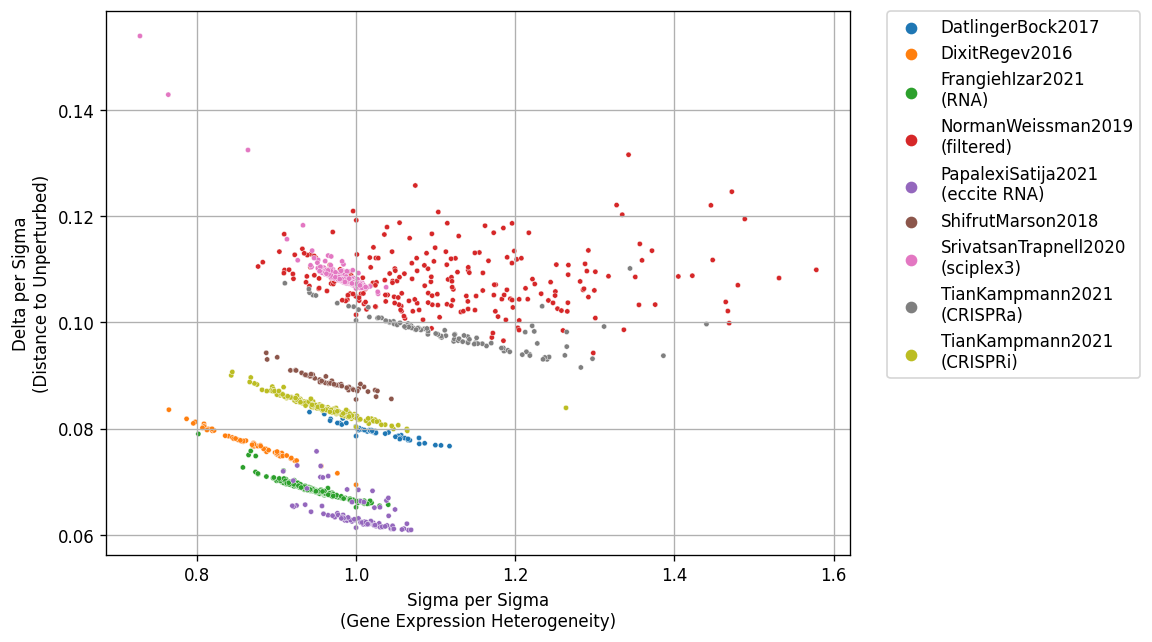

In [265]:
pl.figure(figsize=[8,6], dpi=120)
# sns.scatterplot(data=df, x='sps', y='dps', hue='dataset', s=10)
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10)
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
pl.grid()
pl.xlabel('Sigma per Sigma\n(Gene Expression Heterogeneity)')
pl.ylabel('Delta per Sigma\n(Distance to Unperturbed)')
# pl.title('Heterogeneity vs Distance\nw.r.t. Unperturbed for Selected Datasets')
pl.show()

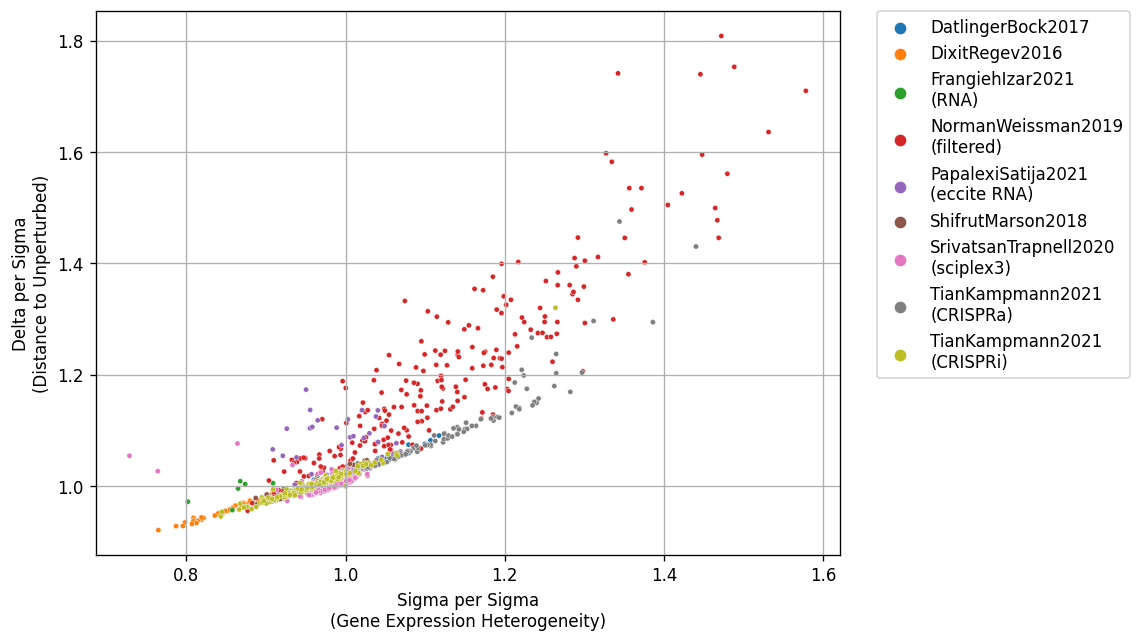

In [124]:
pl.figure(figsize=[8,6], dpi=120)
# sns.scatterplot(data=df, x='sps', y='dps', hue='dataset', s=10)
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10)
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
pl.grid()
pl.xlabel('Sigma per Sigma\n(Gene Expression Heterogeneity)')
pl.ylabel('Delta per Sigma\n(Distance to Unperturbed)')
# pl.title('Heterogeneity vs Distance\nw.r.t. Unperturbed for Selected Datasets')
pl.show()

<AxesSubplot:xlabel='sps', ylabel='dps'>

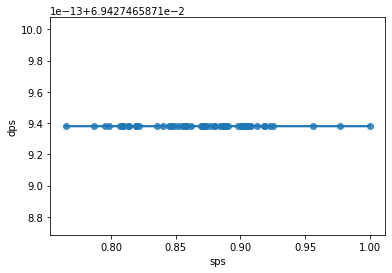

In [251]:
sns.regplot(data=df[df.dataset=='DixitRegev2016'], x='sps', y='dps')


<AxesSubplot:xlabel='sps', ylabel='dps'>

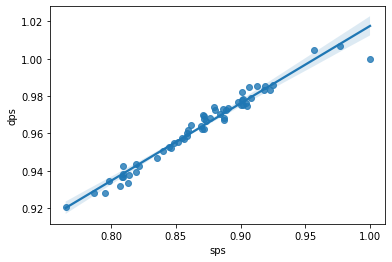

In [158]:
sns.regplot(data=df[df.dataset=='DixitRegev2016'], x='sps', y='dps')


In [169]:
pd.unique(df.dataset)

array(['DatlingerBock2017', 'DixitRegev2016', 'FrangiehIzar2021\n(RNA)',
       'NormanWeissman2019\n(filtered)',
       'PapalexiSatija2021\n(eccite RNA)',
       'SchraivogelSteinmetz2020\n(chromosome 11 screen)',
       'ShifrutMarson2018', 'SrivatsanTrapnell2020\n(sciplex3)',
       'TianKampmann2021\n(CRISPRa)', 'TianKampmann2021\n(CRISPRi)'],
      dtype=object)

In [222]:
df[df.dataset=='NormanWeissman2019\n(filtered)'].sort_values('dps')

,dataset,perturbation,sps,perturbation_type,organism,tissue_type,cell_line,cancer,disease,celltype,dps
575,NormanWeissman2019\n(filtered),BCL2L11_BAK1,0.876965,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,0.955612
412,NormanWeissman2019\n(filtered),MAML2,0.882836,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,0.969066
419,NormanWeissman2019\n(filtered),ISL2,0.909313,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,0.979685
386,NormanWeissman2019\n(filtered),RUNX1T1,0.921395,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,0.983098
377,NormanWeissman2019\n(filtered),ELMSAN1,0.910179,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,0.985839
...,...,...,...,...,...,...,...,...,...,...,...
598,NormanWeissman2019\n(filtered),CEBPB_CEBPA,1.578214,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,1.710041
571,NormanWeissman2019\n(filtered),CEBPE_CEBPA,1.445800,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,1.739692
572,NormanWeissman2019\n(filtered),CEBPE_SPI1,1.342334,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,1.741363
447,NormanWeissman2019\n(filtered),CEBPA,1.488337,CRISPR,human,cell_line,K562,True,chronic myelogenous leukemia,lymphoblasts,1.753142


In [228]:
list(df[df.dataset=='NormanWeissman2019\n(filtered)'].sort_values('dps').perturbation)[:3]

['BCL2L11_BAK1', 'MAML2', 'ISL2']

In [227]:
list(df[df.dataset=='NormanWeissman2019\n(filtered)'].sort_values('dps').perturbation)[-3:]

['CEBPE_SPI1', 'CEBPA', 'JUN_CEBPA']

In [181]:
from sklearn.linear_model import LinearRegression
# mask = [True]*len(df)#np.isin(df.dataset, ['TianKampmann2021\n(CRISPRi)', 'TianKampmann2021\n(CRISPRa)', 'DixitRegev2016'])
mask = ~np.isin(df.dataset, ['NormanWeissman2019\n(filtered)', 'SchraivogelSteinmetz2020\n(chromosome 11 screen)'])
X = df[mask].sps.values.reshape(-1, 1)
y = df[mask].dps.values
reg = LinearRegression().fit(X, y)

a = reg.coef_[0]
b = reg.intercept_
r = reg.score(X, y)

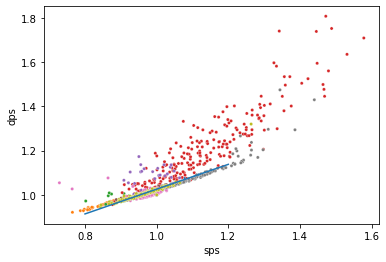

In [200]:
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10, legend=False)
# pl.xlim([0.8,1.2])
# pl.ylim([0.9,1.1])
pl.plot([0.8,1.2], [a*0.8+b, a*1.2+b])
pl.show()

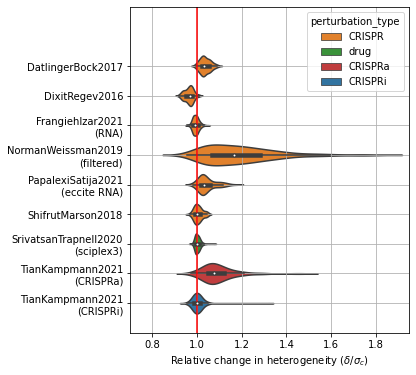

In [229]:
pl.figure(figsize=[5,6])
sns.violinplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], y='dataset', x='dps', width=0.7, hue='perturbation_type', dodge=False, palette=colors_perturbation_types)
pl.axvline(1, color='red')
pl.ylim(len(cool_ones)-1, -2)
pl.xlim(0.7, 1.95)
pl.grid()
pl.ylabel('')
pl.xlabel(r'Relative change in heterogeneity ($\delta/\sigma_c$)')
# pl.title('Shift in Gene Expression ($\delta$)'+'\nafter Perturbation w.r.t. Unperturbed '+r'($\sigma_c$)')
pl.savefig('../../figures/delta_per_sigma.pdf', bbox_inches='tight')
pl.show()

# DEPRECATED: pseudobulk distances

I dont get it

## without pca

In [19]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + 'ZhaoSims2021' + '.h5')
bdata = pseudo_bulk(adata, ['perturbation'])
# sc.pp.pca(bdata)
Z = bdata.X#obsm['X_pca']
from sklearn.metrics import pairwise_distances
M = pairwise_distances(Z)/Z.shape[-1]  # mean pairwise GEX distance per gene
tab=pd.DataFrame(M, index=bdata.obs.perturbation, columns=bdata.obs.perturbation)
tab = cluster_matrix(tab, 'both')
df = tab
df

perturbation,control,etoposide,Ana-12,Ispenisib,RO4929097,panobinostat,Tazemetostat
perturbation,,,,,,,
control,0.000000,3.629887,7.726338,10.112219,6.723669,6.377066,7.627846
etoposide,3.629887,0.000000,10.022079,11.859972,8.636304,7.725365,9.107672
Ana-12,7.726338,10.022079,0.000000,4.986882,5.500310,8.436950,7.158165
Ispenisib,10.112219,11.859972,4.986882,0.000000,6.032993,8.835092,7.770849
RO4929097,6.723669,8.636304,5.500310,6.032993,0.000000,5.823655,5.625077
panobinostat,6.377066,7.725365,8.436950,8.835092,5.823655,0.000000,5.470557
Tazemetostat,7.627846,9.107672,7.158165,7.770849,5.625077,5.470557,0.000000


In [21]:
# mean std per gene
mean_std_per_dim = [np.mean(np.std(adata[adata.obs.perturbation==p].X.A, axis=0)) for p in pd.unique(adata.obs.perturbation)]

In [22]:
mean_std_per_dim

[0.12583247,
 0.12321542,
 0.12676674,
 0.11087782,
 0.111985266,
 0.11519072,
 0.11265035]

In [24]:
sc.tl.umap(adata)

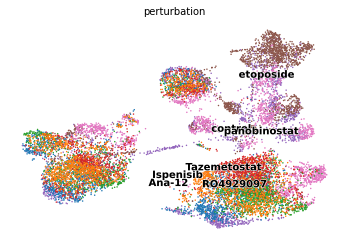

In [25]:
scv.pl.scatter(adata, color='perturbation', basis='umap')

## with pca

In [29]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + 'ZhaoSims2021' + '.h5')
bdata = pseudo_bulk(adata, ['perturbation'])
sc.pp.pca(bdata)
Z = bdata.obsm['X_pca']
from sklearn.metrics import pairwise_distances
M = pairwise_distances(Z)
tab=pd.DataFrame(M, index=bdata.obs.perturbation, columns=bdata.obs.perturbation)
tab = cluster_matrix(tab, 'both')
df = tab
df

perturbation,control,etoposide,Ispenisib,panobinostat,Tazemetostat,Ana-12,RO4929097
perturbation,,,,,,,
control,0.000000,56008.394531,180539.468750,142927.281250,120066.445312,97275.054688,131990.750000
etoposide,56008.394531,0.000000,210939.250000,159728.500000,137552.812500,140091.140625,164116.187500
Ispenisib,180539.468750,210939.250000,0.000000,158044.609375,132308.093750,120691.882812,109682.703125
panobinostat,142927.281250,159728.500000,158044.609375,0.000000,89835.085938,155466.906250,125639.945312
Tazemetostat,120066.445312,137552.812500,132308.093750,89835.085938,0.000000,126869.562500,118136.062500
Ana-12,97275.054688,140091.140625,120691.882812,155466.906250,126869.562500,0.000000,98160.585938
RO4929097,131990.750000,164116.187500,109682.703125,125639.945312,118136.062500,98160.585938,0.000000


In [134]:
Z.shape

(7, 6)

In [135]:
Y = adata.obsm['X_pca']

In [131]:
np.std(Z, axis=1).shape

(26164,)

In [24]:
mean_std_per_dim = [np.mean(np.std(adata.obsm['X_pca'][adata.obs.perturbation==p], axis=0)) for p in pd.unique(adata.obs.perturbation)]